<p style="text-align: left; font-size: 32px; font-weight: bold;">
    Creating animated gifs with NEXRAD Level 2 radar data using Py-ART
</p>


# Overview
### Within this notebook, we will cover:
#### 1: Accessing NEXRAD data from AWS
#### 2: How to read the data into Py-ART and create plots
#### 3: How to create animated gifs with acquired radar data from Py-ART

# Prerequisites 


| Concepts | Importance | Notes |
| -------- | ---------- | ----- |
| [Quickstart: Zero to Python](https://foundations.projectpythia.org/foundations/quickstart.html) | Required | For loops, lists |
| [Matplotlib Basics](https://link-to-matplotlib-basics) | Required | Basic plotting |
| [Py-ART Basics](https://link-to-pyart-basics) | Required | IO/Visualization |
| [The Basics of Weather Radar](https://projectpythia.org/radar-cookbook/notebooks/radar-basics/radar-basics.html) | Required | Competency with Radar and its products |

* **Time to learn:** 30 Minutes


# Imports for animated gif making in PyArt 

In [73]:
import pyart
import fsspec
import matplotlib.pyplot as plt
import os
from io import BytesIO
import warnings
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display, Image as IPImage
warnings.filterwarnings("ignore")

%matplotlib inline

### Set up the AWS S3 filysystem
This allows you to pull nexrad-level-2 data files from the AWS repository.

In [76]:
fs = fsspec.filesystem("s3", anon=True)

### Selecting your date, station, and time period

Once the file system is set up, you can use the following code to specify what time, date, and station you'd like to retrieve data for

For this example, we will use data from NWS Chicago (KLOT) from 04 UTC, June 5th, 2024


In [80]:
start_date = datetime(2024, 6, 5, 4, 0)  # YYYY/MM/DD HH
end_date = datetime(2024, 6, 6, 10, 0)   # YYYY/MM/DD HH
station = 'KLOT'

### OPTIONAL* setting up individual locations to be plotted on your map

In this example, two plots are pointed due to their relevance to the example weather event: The ATMOS facility at Argonne National Laboratory, Lemont, IL, and Sawmill Creek in Darien, IL. The latitude and longitude for each site should be placed at the same index (IE. Index 0 in both latitude and longitude should contain the latitude and longitude data for that one site. This also applies to the labels, markers, and colors. Any object in the index 0 slot will apply to that same point.)



In [83]:
latitude = [41.700937896518866, 41.73884644555692] 
longitude = [-87.99578103231573, -87.98744136114946]
labels = ['Tower', 'SCM']
markers = ['v', 'o']
colors = ['magenta', 'cyan']

# Generating your file list

In [ ]:
files = []
current_date = start_date

while current_date <= end_date:
    date_str = current_date.strftime("%Y/%m/%d")
    date_str_compact = current_date.strftime("%Y%m%d")

    if current_date.date() == start_date.date():
        start_hour = start_date.hour
    else:
        start_hour = 0

    if current_date.date() == end_date.date():
        end_hour = end_date.hour
    else:
        end_hour = 23

    for hour in range(start_hour, end_hour + 1):
        hour_str = f"{hour:02d}"
        all_files = fs.glob(f"s3://noaa-nexrad-level2/{date_str}/{station}/{station}{date_str_compact}_{hour_str}*")
        filtered_files = [f for f in all_files if not f.endswith('_MDM')]
        files += sorted(filtered_files)

    current_date = current_date.replace(hour=0) + timedelta(days=1)

# Print the selected files
print("Selected files:")
for file in files:
    print(file)

### Checking your plottable radar products
This function reads one of the radar files in your file list and prints out the available products for plotting. One file should represent all products available in each radar file in the list. Although if you are pulling data from files pre 2011, dual-pol products won't be available. 

In [88]:
def check_radar_fields(file_path):
    try:
        with fs.open(file_path, 'rb') as f:
            radar_data = f.read()
        radar_file = BytesIO(radar_data)
        radar = pyart.io.read_nexrad_archive(radar_file)
        print(f"Fields in radar data from {file_path}:")
        print(list(radar.fields.keys()))
    except Exception as e:
        print(f"Failed to read radar data from {file_path}: {e}")

# Check the fields for the first file
if files:
    check_radar_fields(files[0])

Fields in radar data from noaa-nexrad-level2/2024/06/05/KLOT/KLOT20240605_040442_V06:
['reflectivity', 'clutter_filter_power_removed', 'velocity', 'cross_correlation_ratio', 'spectrum_width', 'differential_reflectivity', 'differential_phase']


# Reading the data into PyART

To streamline the process of pulling and processing the radar files, we will create a function called read_radar_data. 

Within this function, some progress tracking code is implemented. Each time a file is successfully read, a message will be printed out letting you know what file in the order it is. This is useful to tell if your code is actually working.
An exception is added to this code so that the files marked MDM (shown on the list of filed compiled when pulling data) do not halt the process, and are instead skipped as they are not necessary.  




In [94]:
def read_radar_data(file_path):
    try:
        with fs.open(file_path, 'rb') as f:
            radar_data = f.read()
        radar_file = BytesIO(radar_data)
        radar = pyart.io.read_nexrad_archive(radar_file)
        print(f"Successfully read radar data from {file_path}")
        return radar
    except Exception as e:
        print(f"Failed to read radar data from {file_path}: {e}")
        return None

### Looping through the radar data

This code allows us to loop through each radar file read. A progress message is printed when a new file has started being processed. 
The if statement tells the code to skip files that are unable to be read.

In [ ]:
for i, file in enumerate(files):
    print(f"Processing file {i+1}/{len(files)}: {file}")
    radar = read_radar_data(file)
    if radar is None:
        print(f"Skipping file {file} due to read error.")
        continue

### Plotting code with added features and plotted points

The radar product being plotted can be changed based on the needs of the individual, but for this example, we will use reflectivity to make a singular gif. 

### Customizing the range of plotted data
Vmin and vmax represent the range of dBz values you'd like to plot on the radar. Sometimes, one may want to raise the lower limit to reduce clutter or nonmeteorological scatter that often appears as low reflectivity blobs near the radar. Basically the maximum and minimum values for your colorbar as well.

The sweep is the elevation being scanned. For example, sweep 0 is the lowest level scanned by the radar. 

### Counties

Counties can be added with the ax.add_feature line. Further additions can be made using cartopy.cfeature if needed. 

### Location plotting 
The for loop in this cell is used to plot the location data provided in the aforementioned variables. 

### Zooming 
The x and ylim functions will allow you to control the zoom on your plot. The grid on the plot is representative of latitude (y) and longitude (x) lines. For this example, we are zoomed in over the points.

### Colorbar
The built in colorbar is disabled and one was created manually to make it fit the image better. Purely an aesthetic decision.

### NOTE 
This code is meant to go under the for loop. Don't run it on its own as it won't work as intended. Full code block will be below

In [ ]:
fig = plt.figure(figsize=[12, 8])
ax = plt.subplot(111, projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
try:
    display.plot_ppi_map('reflectivity',
                         sweep=0,
                         vmin=10,
                         vmax=65,
                         ax=ax,
                         title=f'Z for {os.path.basename(file)}',
                         cmap='pyart_ChaseSpectral',
                         colorbar_flag=False)  # Disable the built-in colorbar
    mappable = display.plots[0]
except Exception as e:
    print(f"Error plotting radar data for file {file}: {e}")
    plt.close(fig)
    continue

# Set the extent to zoom in much closer and centered on the points
plt.xlim(-88.1, -87.8)
plt.ylim(41.6, 41.8)

# Add counties
ax.add_feature(USCOUNTIES, linewidth=0.5)

for lat, lon, label, marker, color in zip(latitude, longitude, labels, markers, colors):
    ax.plot(lon, lat, marker, label=label, color=color, transform=ccrs.PlateCarree(), markersize=10)

# Create a colorbar manually
plt.tight_layout()
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('equivalent reflectivity factor (dBZ)')

# Save the plot to a file
filename = f'radar_frame_{i}.png'
plt.legend(loc='upper right', fontsize='large', title='Locations')
plt.savefig(filename, bbox_inches='tight')
plt.close(fig)

# Add the file to the frames list
frames.append(filename)
print(f"Saved frame {i+1}/{len(files)}: {filename}")


### Full code block constructed properly within the for loop.

In [ ]:
for i, file in enumerate(files):
    radar = read_radar_data(file)
    if radar is None:
        print(f"Skipping file {file} due to read error.")
        continue

    # Create a plot for the first sweep's reflectivity
    fig = plt.figure(figsize=[12, 8])
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    display = pyart.graph.RadarMapDisplay(radar)
    try:
        display.plot_ppi_map('reflectivity',
                             sweep=0,
                             vmin=10,
                             vmax=65,
                             ax=ax,
                             title=f'Z for {os.path.basename(file)}',
                             cmap='pyart_ChaseSpectral',
                             colorbar_flag=False)  # Disable the built-in colorbar
        mappable = display.plots[0]
    except Exception as e:
        print(f"Error plotting radar data for file {file}: {e}")
        plt.close(fig)
        continue

    # Set the extent to zoom in much closer and centered on the points
    plt.xlim(-88.2, -87.7)
    plt.ylim(41.5, 41.9)

    # Add counties
    ax.add_feature(USCOUNTIES, linewidth=0.5)

    for lat, lon, label, marker, color in zip(latitude, longitude, labels, markers, colors):
        ax.plot(lon, lat, marker, label=label, color=color, transform=ccrs.PlateCarree(), markersize=10)

    # Create a colorbar manually
    plt.tight_layout()
    cbar = plt.colorbar(mappable, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('equivalent reflectivity factor (dBZ)')

    # Save the plot to a file
    filename = f'radar_frame_{i}.png'
    plt.legend(loc='upper right', fontsize='large', title='Locations')
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)

    # Add the file to the frames list
    frames.append(filename)
    print(f"Saved frame {i+1}/{len(files)}: {filename}")

# GIF creation

We can now use the data to create a gif out of the frames we've appended to our list. 

This code also includes code to save the gif to your local directory.

Something to note, if you do not want to save the gif, you can get rid of this code.

As the frames are processed, they will temporarily save to your directory until the gif is made. They will save as PNG files, which are able to be opened and can be used to make sure everything is plotting on your figure correctly.



In [ ]:
# Create an animated GIF using Pillow
if frames:
    print("Creating animated GIF...")
    images = [Image.open(frame) for frame in frames]
    gif_filename = 'radar_animation.gif'
    images[0].save(gif_filename, save_all=True, append_images=images[1:], duration=300, loop=0)  # duration in milliseconds

    # Clean up the saved frames
    for filename in frames:
        os.remove(filename)

    print("Animated GIF created as 'radar_animation.gif'")
    
    with open(gif_filename, 'rb') as f:
        display(IPImage(data=f.read(), format='gif'))
else:
    print("No frames were generated.")

# Code in whole

Animated GIF created as 'radar_animation.gif'


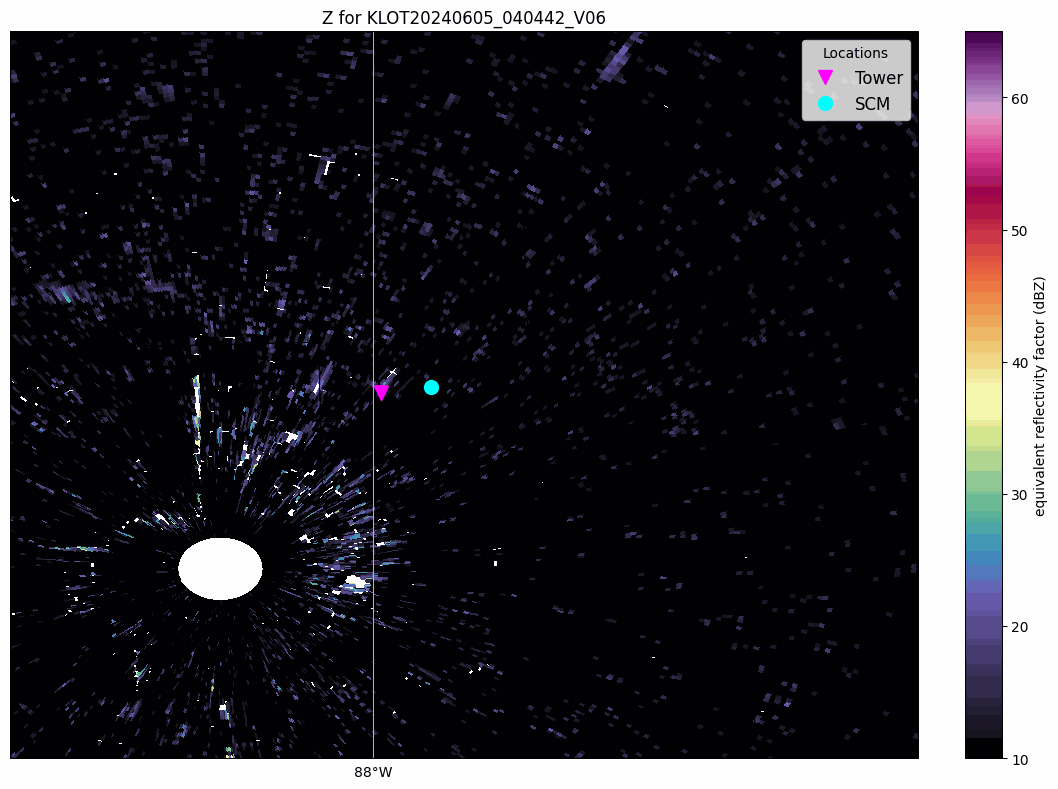

In [36]:
import pyart
import fsspec
import matplotlib.pyplot as plt
import os
from io import BytesIO
import warnings
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
from PIL import Image
from datetime import datetime, timedelta
from IPython.display import display, Image as IPImage
%matplotlib inline

warnings.filterwarnings("ignore")

fs = fsspec.filesystem("s3", anon=True)

# Define the start and end dates and hours
start_date = datetime(2024, 6, 5, 4, 0)  # YYYY/MM/DD HH
end_date = datetime(2024, 6, 5, 4, 0)   # YYYY/MM/DD HH
station = 'KLOT'
latitude = [41.700937896518866, 41.704120]
longitude = [-87.99578103231573, -87.968328]
labels = ['Tower', 'SCM']
markers = ['v', 'o']
colors = ['magenta', 'cyan']

# Generate the list of files for the specified date and hour range
files = []
current_date = start_date

while current_date <= end_date:
    date_str = current_date.strftime("%Y/%m/%d")
    date_str_compact = current_date.strftime("%Y%m%d")

    if current_date.date() == start_date.date():
        start_hour = start_date.hour
    else:
        start_hour = 0

    if current_date.date() == end_date.date():
        end_hour = end_date.hour
    else:
        end_hour = 23

    for hour in range(start_hour, end_hour + 1):
        hour_str = f"{hour:02d}"
        all_files = fs.glob(f"s3://noaa-nexrad-level2/{date_str}/{station}/{station}{date_str_compact}_{hour_str}*")
        filtered_files = [f for f in all_files if not f.endswith('_MDM')]
        files += sorted(filtered_files)

    current_date = current_date.replace(hour=0) + timedelta(days=1)

# Function to read radar data
def read_radar_data(file_path):
    try:
        with fs.open(file_path, 'rb') as f:
            radar_data = f.read()
        radar_file = BytesIO(radar_data)
        radar = pyart.io.read_nexrad_archive(radar_file)
        #print(f"Successfully read radar data from {file_path}")
        return radar
    except Exception as e:
        print(f"Failed to read radar data from {file_path}: {e}")
        return None

# Create directories for the frames
frames_dir = 'frames/PPI'
os.makedirs(frames_dir, exist_ok=True)

# Create frames for the animated GIF
frames = []

# Loop through each radar file
for i, file in enumerate(files):
    radar = read_radar_data(file)
    if radar is None:
        print(f"Skipping file {file} due to read error.")
        continue

    # Create a plot for the first sweep's reflectivity
    fig = plt.figure(figsize=[12, 8])
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    radar_display = pyart.graph.RadarMapDisplay(radar)
    try:
        radar_display.plot_ppi_map('reflectivity',
                                   sweep=0,
                                   vmin=10,
                                   vmax=65,
                                   ax=ax,
                                   title=f'Z for {os.path.basename(file)}',
                                   cmap='pyart_ChaseSpectral',
                                   colorbar_flag=False)  # Disable the built-in colorbar
        mappable = radar_display.plots[0]
    except Exception as e:
        print(f"Error plotting radar data for file {file}: {e}")
        plt.close(fig)
        continue

    # Set the extent to zoom in much closer and centered on the points
    plt.xlim(-88.2, -87.7)
    plt.ylim(41.5, 41.9)

    # Add counties
    ax.add_feature(USCOUNTIES, linewidth=0.5)

    for lat, lon, label, marker, color in zip(latitude, longitude, labels, markers, colors):
        ax.plot(lon, lat, marker, label=label, color=color, transform=ccrs.PlateCarree(), markersize=10)

    # Create a colorbar manually
    plt.tight_layout()
    cbar = plt.colorbar(mappable, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('equivalent reflectivity factor (dBZ)')

    # Save the plot to a file
    filename = os.path.join(frames_dir, f'radar_frame_{i}.png')
    plt.legend(loc='upper right', fontsize='large', title='Locations')
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)

    # Add the file to the frames list
    frames.append(filename)
    

# Create an animated GIF using Pillow
if frames:
    images = [Image.open(frame) for frame in frames]
    gif_filename = 'radar_animation.gif'
    images[0].save(gif_filename, save_all=True, append_images=images[1:], duration=300, loop=0)  # duration in milliseconds

    # Clean up the saved frames
    for filename in frames:
        os.remove(filename)

    print("Animated GIF created as 'radar_animation.gif'")

    # Display the GIF in the notebook
    with open(gif_filename, 'rb') as f:
        display(IPImage(data=f.read(), format='gif'))
else:
    print("No frames were generated.")


# Summary
Within this example, we walked through how MetPy and PyART can be used to loop through NEXRAD level 2 data from a recent convective rainfall event and create an animated gif over a location.